# League Creep Score Analysis

**Name(s)**: Haris Saif, Ernest Ibarolle

**Website Link**: https://eibarolle.github.io/LoL-Creep-Score-Study/

In [45]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
pd.options.plotting.backend = 'plotly'
from dsc80_utils import *

## Step 1: Introduction

In [46]:
data = Path('data') / 'LoL_2022.csv'
df = pd.read_csv(data, dtype='unicode')
df


gameid datacompleteness  \
0       ESPORTSTMNT01_2690210         complete   
1       ESPORTSTMNT01_2690210         complete   
2       ESPORTSTMNT01_2690210         complete   
...                       ...              ...   
150177       9687-9687_game_5          partial   
150178       9687-9687_game_5          partial   
150179       9687-9687_game_5          partial   

                                                url league  ... deathsat25  \
0                                               NaN   LCKC  ...          1   
1                                               NaN   LCKC  ...          2   
2                                               NaN   LCKC  ...          0   
...                                             ...    ...  ...        ...   
150177  https://lpl.qq.com/es/stats.shtml?bmid=9687   DCup  ...        NaN   
150178  https://lpl.qq.com/es/stats.shtml?bmid=9687   DCup  ...        NaN   
150179  https://lpl.qq.com/es/stats.shtml?bmid=9687   DCup  ...        NaN   

       opp_killsat25 opp_assistsat25 opp_deathsat25  
0                  0               2              0  
1                  1               5              1  
2                  3               4              3  
...              ...             ...            ...  
150177           NaN             NaN            NaN  
150178           NaN             NaN            NaN  
150179           NaN             NaN            NaN  

[150180 rows x 161 columns]

In [47]:
df['earnedgold']

0          7164
1          5368
2          5945
          ...  
150177     4811
150178    26462
150179    39998
Name: earnedgold, Length: 150180, dtype: object

In [48]:
df.columns.values

array(['gameid', 'datacompleteness', 'url', ..., 'opp_killsat25',
       'opp_assistsat25', 'opp_deathsat25'], dtype=object)

In [49]:
df[0:24][['gameid', 'participantid', 'playername', 'teamname', 'position', 'cspm']]

gameid participantid playername            teamname  \
0   ESPORTSTMNT01_2690210             1     Soboro   BRION Challengers   
1   ESPORTSTMNT01_2690210             2     Raptor   BRION Challengers   
2   ESPORTSTMNT01_2690210             3     Feisty   BRION Challengers   
..                    ...           ...        ...                 ...   
21  ESPORTSTMNT01_2690219            10      Prove  Liiv SANDBOX Youth   
22  ESPORTSTMNT01_2690219           100        NaN  T1 Esports Academy   
23  ESPORTSTMNT01_2690219           200        NaN  Liiv SANDBOX Youth   

   position     cspm  
0       top   8.0911  
1       jng   5.1839  
2       mid   6.7601  
..      ...      ...  
21      sup   1.5610  
22     team  34.3141  
23     team  35.6764  

[24 rows x 6 columns]

### Introduction and Question Identification

League of Legends is a popular multiplayer online battle arena, or MOBA, game developed by Riot Games in 2009. With over 100 million registered players worldwide, it is one of the most influental games in esports history. To analyze competitive matches, we will be working with a professional data set developed by Oracle’s Elixir containing official League matches from 2022. This dataset includes various identifications and gameplay metrics from these matches, like player position, champion choices, kills, and earned gold. These variables are useful for analyzing gameplay viability and goals. 

While playing League of Legends, one of the main ways to get gold is by killing monsters around the map, including respawning minions and shared objectives teams fight over. The statistical metric "creep score" keeps track of every monster killed, with a general rule of thumb that every basic minion killed awards 1 creep score. With more monsters killed and thus more gold, the player can purchase stat increasing items, which could theoretically improve chances of victory and change gameplay strategies.

The central question we are interested in the relationship creep score per minute (cspm) has to other gameplay variables and metrics, including win rate. CSPM is used over creep score in general to account for varying game lengths. Using data analysis, the impact cspm and other statistics have on each other can be measured and tested. We can then utilize these given features to predict cspm. This predictive model can be used to strategize around high cspm objectives and picks, as well as improve the user's gameplay.

Introduction of Columns
This Oracle's Elixir dataset includes various identifications and gameplay metrics from competitive League matches in 2022. There are 150180 rows in this dataset, as well as 161 columns/variables. Here is a list of the key columns analyzed:

- gameid: Contains a unique string identifier representing an individual match.

- participantid: Contains an integer representing the participant's id. 1-5 represents a Red team player, 6-10 represents a Blue team player, 100 represents the Red team itself, and 200 represents the Blue team itself.

- result: Contains an integer representing the outcome of a match for the corresponding participant. 1 represents a win, 0 represents a loss.

- patch: Contains a string representing the game patch the match was played in.

- cspm: Contains a float representing the average monsters + minions killed per minute.

- kills: Contains an integer representing how many times a participant lands a finishing blow on an enemy champion.

- position: Contains a string represents the participant's position (top, jg, mid, adc, sup, or team itself).

- champion: Contains a string represents the champion picked by the participant.

- totalgold: Contains a int representing the overall amount of gold a player gained throughout the match from individual and shared actions.

- earnedgold: Contains a int representing the overall amount of gold a player gained throughout the match solely from individual actions.

- league: Contains a string represents the specific league tournament the match was held in, such as LEC for European matches.

## Step 2: Data Cleaning and Exploratory Data Analysis

### Data Cleaning

In [50]:
# Cleans the dataset by using astype() for numerical columns, using replace() for null values, creating a new column based off cspm's missingness, and dividing the dataset into the type of participant based off the id.
df['result'] = df['result'].astype(int)
df['earnedgold'] = df['earnedgold'].astype(float)
df['totalgold'] = df['totalgold'].astype(float)
df['cspm'] = df['cspm'].astype(float)
df['kills'] = df['kills'].astype(int)
df.replace("", np.nan, inplace=True)
df['cspm_missing'] = df['cspm'].apply(lambda x: "Yes" if pd.isnull(x) else "No")
teams = df[(df['participantid'] == '100') | (df['participantid'] == '200')]
players = df[(df['participantid'] != '100') & (df['participantid'] != '200')]

### Univariate Analysis

In [51]:
# Plotting CSPM as a Plotly Histogram
cspm_plot = px.histogram(df, x='cspm', nbins=50, title = 'Histogram of CSPM for 2022 LoL Participants')
cspm_plot.write_html('plots/cspm_plot.html', include_plotlyjs='cdn')
cspm_plot

In [52]:
# Plotting Earned Gold as a Plotly Histogram
earned_plot = px.histogram(df, x='earnedgold', nbins=50, title = 'Histogram of Earned Gold for 2022 LoL Participants')
earned_plot.write_html('plots/earned_plot.html', include_plotlyjs='cdn')
earned_plot

### Bivariate Analysis

In [53]:
# Plotting CSPM vs Earned Gold as a Plotly Scatterplot
cspm_gold_scatter = px.scatter(df, x = 'cspm', y = 'earnedgold', title = 'CSPM vs Earned Gold Scatterplot for 2022 LoL Participants')
cspm_gold_scatter.write_html('plots/cspm_gold_scatter.html', include_plotlyjs='cdn')
cspm_gold_scatter

In [54]:
# Plotting CSPM vs Kills as a Plotly Scatterplot
cspm_kills_scatter = px.scatter(df, x = 'cspm', y = 'kills', title = 'CSPM vs Kills Scatterplot for 2022 LoL Participants')
cspm_kills_scatter.write_html('plots/cspm_kills_scatter.html', include_plotlyjs='cdn')
cspm_kills_scatter

### Interesting Aggregates

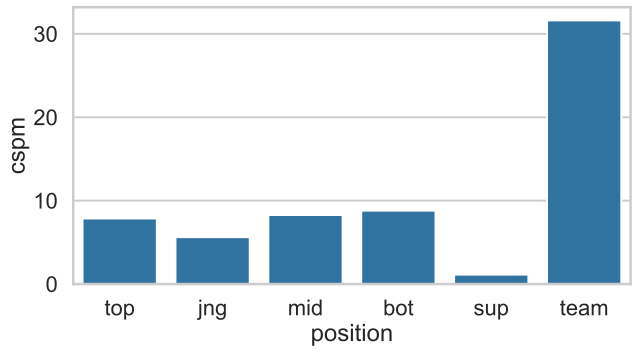

In [55]:
# Grouping and Plotting CSPM based off Position
position_cspm = df.groupby('position').mean(numeric_only=True)['cspm']
position_cspm = position_cspm.loc[['top', 'jng', 'mid', 'bot', 'sup', 'team']]
sns.barplot(data=position_cspm)
plt.show()

In [56]:
# Forming a pivot table off the Position grouping of CSPM
pivot_position = df.pivot_table(index='position', values='cspm', aggfunc='mean')
pivot_position = pivot_position.reindex(['top', 'jng', 'mid', 'bot', 'sup', 'team'])
pivot_position

cspm
position       
top        7.86
jng        5.63
mid        8.28
bot        8.81
sup        1.13
team      31.62

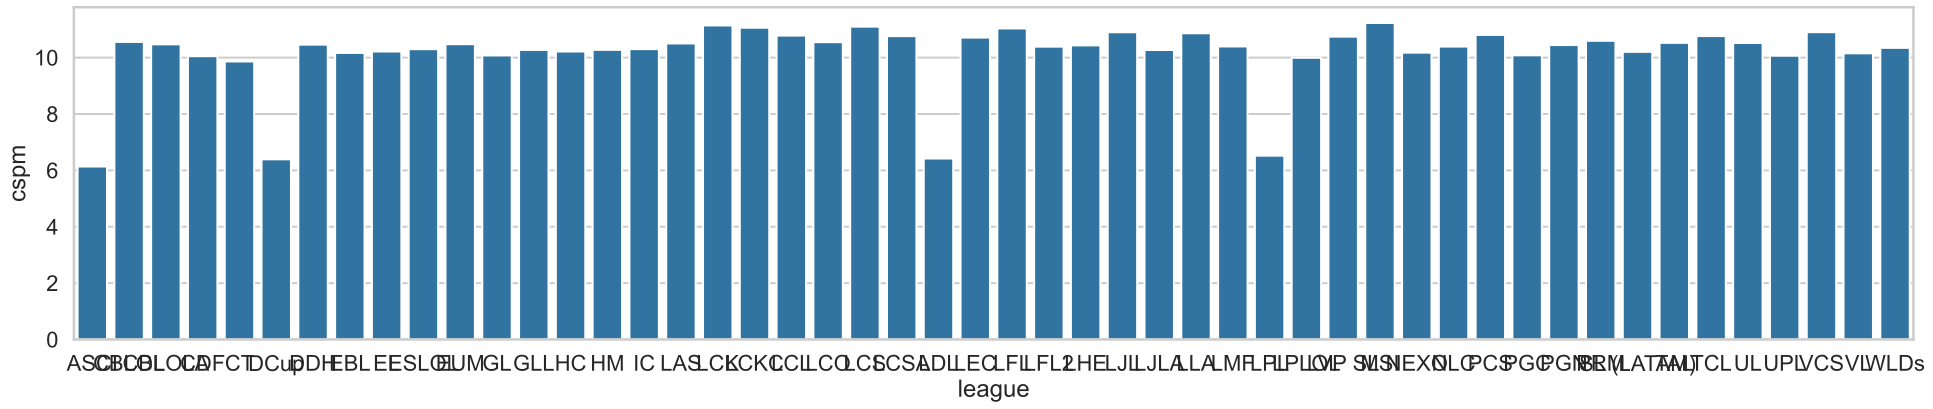

In [57]:
# Grouping and Plotting CSPM based off League
league_cspm = df.groupby('league').mean(numeric_only=True)['cspm']
plt.figure(figsize=(33, 6)) 
sns.barplot(data=league_cspm)
plt.show()

In [58]:
# Forming a pivot table off the League grouping of CSPM
pivot_league = df.pivot_table(index='league', values='cspm', aggfunc='mean')
pivot_league

cspm
league       
ASCI     6.14
CBLOL   10.56
CBLOLA  10.47
...       ...
VCS     10.90
VL      10.15
WLDs    10.35

[50 rows x 1 columns]

## Step 3: Assessment of Missingness

### NMAR Analysis
The column believed to be NMAR (Not Missing At Random) is the column 'teamid'. This is because if a competitive match was played against a newer or exhibition team, they might not have official documentation and thus wouldn't have a teamid. Therefore, this column being missing would depend upon itself and the team circumstances, so it would count as NMAR. In addition, the 'teamid' column being missing doesn't follow any trends from other columns (in other words, no dependency). For additional data to test whether 'teamid' is NMAR or MAR (Missing At Random), it could be useful to record another column 'uniqueteam' on whether each participant has played for the same team throughout all of 2022 or not. This will make it easier to analyze whether the missingness is due to the column itself, the players, or a sampling error.

### Missingness Dependency
The missingness of our focus column, 'cspm', will be tested on against the columns "league" and "side". The significance level chosen is 0.1, and the test statistic will be TVD because both other columns are categorical. For "league", the hypotheses are as follows:
##### Null Hypothesis: The distribution of league when cspm is missing is the same as the distribution of league when cspm isn't missing. In other words, cspm isn't MAR based off league.
##### Alternative Hypothesis: The distribution of league when cspm is missing is not the same as the distribution of league when cspm isn't missing. In other words, cspm is MAR based off league. 

In [68]:
# Takes the value counts of each league's CSPM missingness, and then conducts a permutation test with TVD as the test statistic. The p-value is recorded after 1000 permutations.
team_leagues = df[['league', 'cspm_missing']]
league_grouped = team_leagues.groupby('cspm_missing')['league'].value_counts().unstack(fill_value=0)
league_grouped = league_grouped.div(league_grouped.sum(axis=0), axis=1)
league_tvd = 0.5 * (abs(league_grouped.iloc[0] - league_grouped.iloc[1]).sum())
league_perms = []

for _ in range(1000):
    shuffled = np.random.permutation(team_leagues['cspm_missing'])
    permuted_df = team_leagues.copy()
    permuted_df['missing'] = shuffled
    permuted_grouped = permuted_df.groupby('missing')['league'].value_counts().unstack(fill_value=0)
    permuted_grouped = permuted_grouped.div(permuted_grouped.sum(axis=0), axis=1)
    permuted_tvd = 0.5 * (abs(permuted_grouped.iloc[0] - permuted_grouped.iloc[1]).sum())
    league_perms.append(permuted_tvd)

p_value = np.mean(np.array(league_perms) >= league_tvd)
p_value

np.float64(0.0)

In [82]:
league_tvd

np.float64(24.318279569892475)

In [60]:
league_tvdf = pd.DataFrame({'TVD': league_perms})
league_fig = px.histogram(
    league_tvdf,
    x='TVD',
    nbins=30,
    title="Empirical Distribution of League TVDs from Permutations",
    labels={'TVD': 'TVD'},
    opacity=0.7
)

league_fig.add_vline(
    x=league_tvd,
    line_dash="dash",
    line_color="red",
    annotation_text=f"Observed TVD ({league_tvd:.4f})",
    annotation_position="top right"
)

league_fig.update_layout(
    xaxis_title="TVD",
    yaxis_title="Frequency",
    bargap=0.1,
    template="plotly_white"
)

league_fig.show()
league_fig.write_html("plots/league_tvdf.html")

From the p-value equaling 0.0 and thus being less than the significance level, we can reject the null hypothesis that the distribution of league when cspm is missing is the same as the distribution of league when cspm isn't missing. In other words, the missingness of cspm depends on the league column.

A similar permutation test is conducted on cspm's missingness in relation to team side.
##### Null Hypothesis: The distribution of team side when cspm is missing is the same as the distribution of team side when cspm isn't missing. In other words, cspm isn't MAR based off team side.
##### Alternative Hypothesis: The distribution of team side when cspm is missing is not the same as the distribution of team side when cspm isn't missing. In other words, cspm is MAR based off team side. 

In [69]:
# Takes the value counts of each side's CSPM missingness, and then conducts a permutation test with TVD as the test statistic. The p-value is recorded after 1000 permutations.
team_side = df[['side', 'cspm_missing']]
side_grouped = team_side.groupby('cspm_missing')['side'].value_counts().unstack(fill_value=0)
side_grouped = side_grouped.div(side_grouped.sum(axis=0), axis=1)
side_tvd = 0.5 * (abs(side_grouped.iloc[:, 0] - side_grouped.iloc[:, 1]).sum())
side_perms = []

for _ in range(1000):
    shuffled = np.random.permutation(team_side['cspm_missing'])
    permuted_df = team_side.copy()
    permuted_df['missing'] = shuffled
    permuted_grouped = permuted_df.groupby('missing')['side'].value_counts().unstack(fill_value=0)
    permuted_grouped = permuted_grouped.div(permuted_grouped.sum(axis=0), axis=1)
    permuted_tvd = 0.5 * (abs(permuted_grouped.iloc[:, 0] - permuted_grouped.iloc[:, 1]).sum())
    side_perms.append(permuted_tvd)

p_value = np.mean(np.array(side_perms) >= side_tvd)
p_value

np.float64(1.0)

In [70]:
side_tvdf = pd.DataFrame({'TVD': side_perms})
side_fig = px.histogram(
    side_tvdf,
    x='TVD',
    title="Empirical Distribution of Side TVDs from Permutations",
    labels={'TVD': 'TVD'},
    opacity=0.7
)

side_fig.add_vline(
    x=side_tvd,
    line_dash="dash",
    line_color="red",
    annotation_text=f"Observed TVD ({side_tvd:.4f})",
    annotation_position="top right"
)

side_fig.update_layout(
    xaxis_title="TVD",
    yaxis_title="Frequency",
    bargap=0.1,
    template="plotly_white"
)

side_fig.show()
side_fig.write_html("plots/side_tvdf.html")

From the p-value equaling 1.0 and thus being greater than the significance level, we fail to reject the null hypothesis that the distribution of team side when cspm is missing is the same as the distribution of team side when cspm isn't missing. In other words, the missingness of cspm isn't MAR based on the team side column.

## Step 4: Hypothesis Testing

### Null Hypothesis: 
The proportion of "winning" results among teams with a higher creep score/minute (cspm) from the 2022 League of Legends Dataframe is equal to 0.5. This null hypothesis is chosen because the team rows are from matches against each other, meaning in all cases, one team must win, and the other must lose. Thus, the proportion of "winning" results is ${1}/{2}$, or 0.5.
### Alternative Hypothesis: 
The proportion of "winning" results among teams with a higher creep score/minute from the 2022 League of Legends Dataframe is greater than 0.5. This alternative hypothesis is chosen because we hypothesize that with a larger creep score, teams will be able to accumulate more gold for better stats.
### Test statistic: 
The win rate proportion for teams with a higher creep score/minute. This is chosen because the data can be cleaned and grouped into both results and the team with the higher cspm.
### Significance Level: 
$\alpha$ = 0.05. This significance level is chosen because of its balance between finding significant patterns and reducing statistical errors.

In [84]:
# A new column is created denoting the team with the higher cspm in its match against the other team, with the assumation that each set of consecutive rows is a match. After that, a permutation test is conducted, shuffling CSPM and recording each result's mean shuffled CSPM. After 5000 permutations, the p-value is recorded and tested against the significance level.
teams = teams.dropna(subset=['cspm'])
teams = teams.reset_index(drop=True)
teams['higher_cspm'] = False  # Default all rows to False

# Compare each first row in a pair with the next row
teams.loc[teams.index % 2 == 0, 'higher_cspm'] = teams['cspm'] > teams['cspm'].shift(-1)

# For the second team in each pair, set 'higher_cspm' to the opposite of the first team in the pair
teams.loc[teams.index % 2 == 1, 'higher_cspm'] = teams['cspm'] > teams['cspm'].shift(1)
cleaned_teams = teams[['higher_cspm', 'result']]
cleaned_teams['result'] = cleaned_teams['result'].astype(int)
cleaned_teams.groupby('higher_cspm').mean()
cleaned_teams
permuted_wrs = []
for _ in range(5000):
    permutated_cspm = np.random.permutation(cleaned_teams['higher_cspm'])
    permuted_wrs.append(np.float64(cleaned_teams[permutated_cspm == True]['result'].mean()))
permuted_wrs = np.array(permuted_wrs)
observed_proportion = np.float64(cleaned_teams.groupby('higher_cspm').mean())[1][0]
p_value = (permuted_wrs > observed_proportion).sum() / len(permuted_wrs)
p_value

np.float64(0.0)

In [88]:
observed_proportion

np.float64(0.7771579843055687)

In [ ]:
q4_tvdf = pd.DataFrame({'Win Proportion': permuted_wrs})
q4_fig = px.histogram(
    q4_tvdf,
    x='Win Proportion',
    title="Empirical Distribution of Win Proportions for higher CSPM Teams from Permutations",
    labels={'Win Proportion': 'Win Proportion'},
    opacity=0.7
)

q4_fig.add_vline(
    x=observed_proportion,
    line_dash="dash",
    line_color="red",
    annotation_text=f"Observed Win Proportion ({observed_proportion:.4f})",
    annotation_position="top right"
)

q4_fig.update_layout(
    xaxis_title="Win Proportion",
    yaxis_title="Frequency",
    bargap=0.1,
    template="plotly_white"
)

q4_fig.show()
q4_fig.write_html("plots/q4.html")

### Conclusion: 
Because the p-value for the permutation test was lower than 0.05, we reject the null hypothesis that the proportion of "winning" results among teams with a higher creep score/minute (cspm) from the 2022 League of Legends Dataframe is equal to 0.5.

## Step 5: Framing a Prediction Problem

### Problem Identification
From the last part, we've learned that cspm has a considerable impact on winning results for competitive League of Legends matches. To prioritize this statistic for better games, creating a prediction model based off other columns/variables could be useful, such as league or champion. For this problem, we can utilize **regression** to predict cspm, since it's a numerical variable. So, a prediction problem now arises: **Can we predict a player's creep score/minute based off of other game statistics?**

As stated earlier, creep score/minute will be utilized as the response variable, since it's a reliable measure for creep score that accounts for varying game lengths. To evaluate our model, we will be using the numerical regression metric RMSE (Root Mean Squared Error) for interpretability compared to similar counterparts like MSE and balancing outliers.

## Step 6: Baseline Model

In [65]:

# A baseline regression model is created for predicting cspm, with position and totalgold as features. After the data is 80/20 split into training and test dataset, the features are denoted by if they're categorical or numerical. If the feature is categorical, it's One Hot Encoded using OneHotEncoder(). If numerical, the data is scaled using StandardScaler() instead. After putting each transformer into a ColumnTransformer, a pipeline is created with a LinearRegression() model. Finally, the data is fit and predicted, with its RMSE being recorded.
import pandas as pd

features = ["position", "totalgold"]
target = "cspm"
X = players[features]
y = players[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_features = ["position"]
numerical_features = ["totalgold"]

categorical_transformer = OneHotEncoder(handle_unknown="ignore")
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
        ("num", numerical_transformer, numerical_features),
    ]
)

pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", LinearRegression())])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
print("RMSE:", rmse)

RMSE: 1.2038441955581383


### Model Summary:



## Step 7: Final Model

In [66]:
# TODO

## Step 8: Fairness Analysis

In [67]:
# TODO